<a href="https://colab.research.google.com/github/ahmedbasemdev/-Article-classifiers-NLP/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
import nltk
from tqdm import tqdm
nltk.download('stopwords')

# for visulization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('ggplot')
from collections import Counter

# Model Building
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding , Dense , LSTM, Dropout , Bidirectional , Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
!pip install -q kaggle


In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


 62% 16.0M/25.7M [00:00<00:00, 162MB/s]
100% 25.7M/25.7M [00:00<00:00, 187MB/s]


In [9]:
data = pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews.zip')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
print(f'There are {data.shape[0]} Row and {data.shape[1]} Columns in our dataset')

There are 50000 Row and 2 Columns in our dataset


In [11]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

## Data Preprocessing

In [12]:
data['review'] = data['review'].str.lower()
data['review'][:]

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [13]:
stopWords = nltk.corpus.stopwords.words('english')
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
def removeStopWords(text):
    text = [word for word in text.split() if word not in stopWords]
    text = " ".join(text)
    return text

In [15]:
print(removeStopWords('Hi , I am ahmed this stentent to check removing stop words'))

Hi , I ahmed stentent check removing stop words


In [16]:
data['review'] = data['review'].apply(removeStopWords)

In [17]:
data['review'][0]

"one reviewers mentioned watching 1 oz episode hooked. right, exactly happened me.<br /><br />the first thing struck oz brutality unflinching scenes violence, set right word go. trust me, show faint hearted timid. show pulls punches regards drugs, sex violence. hardcore, classic use word.<br /><br />it called oz nickname given oswald maximum security state penitentary. focuses mainly emerald city, experimental section prison cells glass fronts face inwards, privacy high agenda. em city home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.<br /><br />i would say main appeal show due fact goes shows dare. forget pretty pictures painted mainstream audiences, forget charm, forget romance...oz mess around. first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high levels graphic violence. violence, injustice (crooked guards who'll sold

In [18]:
def removeTags(text):
    text =re.sub('<.*?>',"",text)
    return text

In [19]:
removeTags('I am ahmed this stentent <br /><br />')

'I am ahmed this stentent '

In [20]:
data['review']= data['review'].apply(removeTags)

In [21]:
def removePunctuation(text):
    text = [word for word in text if word not in string.punctuation]
    text = "".join(text)
    return text

In [22]:
removePunctuation("hello !!!")

'hello '

In [23]:
data['review'] = data['review'].apply(removePunctuation)

In [24]:
data.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production the filming techni...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [25]:
data['target']=data['sentiment'].apply(lambda x : 1 if x =="positive" else 0)
data.head()

,review,sentiment,target
0,one reviewers mentioned watching 1 oz episode ...,positive,1
1,wonderful little production the filming techni...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically theres family little boy jake thinks...,negative,0
4,petter matteis love time money visually stunni...,positive,1


## EDA

In [26]:
def getLengthAlphabets(text):
    text = str(text)
    return len(text)

In [27]:
def getLengthWords(text):
    text = str(text)
    return len(text.split(' '))

In [28]:
data['lenAlphabet'] = data['review'].apply(getLengthAlphabets)

In [29]:
data['lenWords'] = data['review'].apply(getLengthWords)

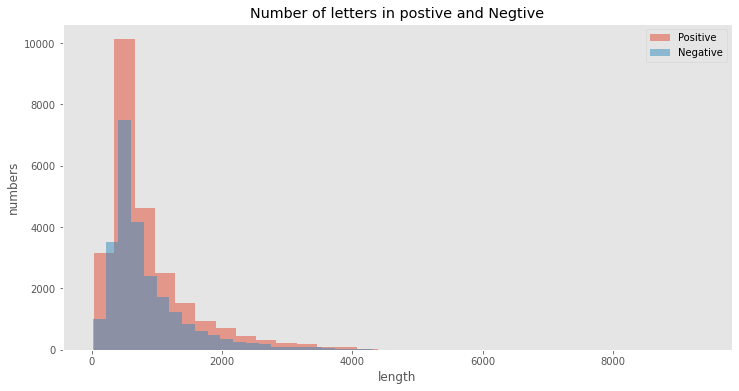

In [30]:
plt.figure(figsize=(12,6))
plt.hist(data[data['sentiment']=="positive"]['lenAlphabet'],label='Positive',alpha = 0.5,bins=30)
plt.hist(data[data['sentiment']=="negative"]['lenAlphabet'],label='Negative',alpha = 0.5,bins=30)
plt.title('Number of letters in postive and Negtive')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.grid()
plt.show()

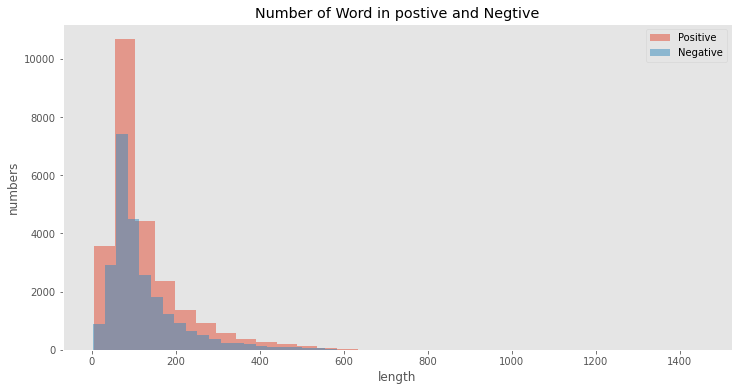

In [31]:
plt.figure(figsize=(12,6))
plt.hist(data[data['sentiment']=="positive"]['lenWords'],label='Positive',alpha = 0.5,bins=30)
plt.hist(data[data['sentiment']=="negative"]['lenWords'],label='Negative',alpha = 0.5,bins=30)
plt.title('Number of Word in postive and Negtive')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.grid()
plt.show()

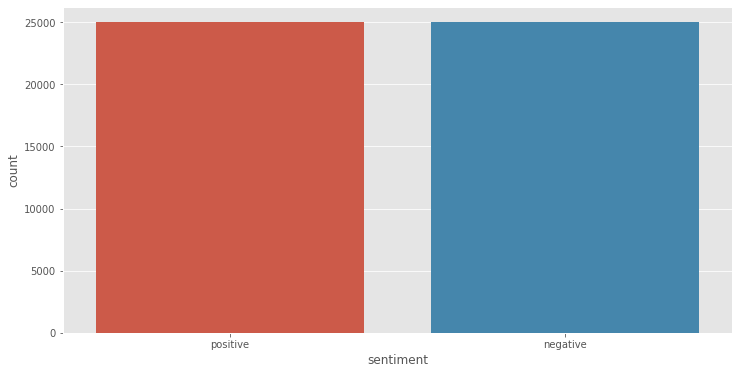

In [32]:
plt.figure(figsize=(12,6))
sns.countplot(data=data , x='sentiment')

In [33]:
text = " ".join(data['review'].tolist())

In [34]:
positiveText = " ".join(data[data['sentiment']=="positive"]['review'].tolist())

In [35]:
len(positiveText.split())

3094893

In [36]:
negativeText = " ".join(data[data['sentiment']=="negative"]['review'].tolist())

In [37]:
len(negativeText.split())

3025444

### UniGram

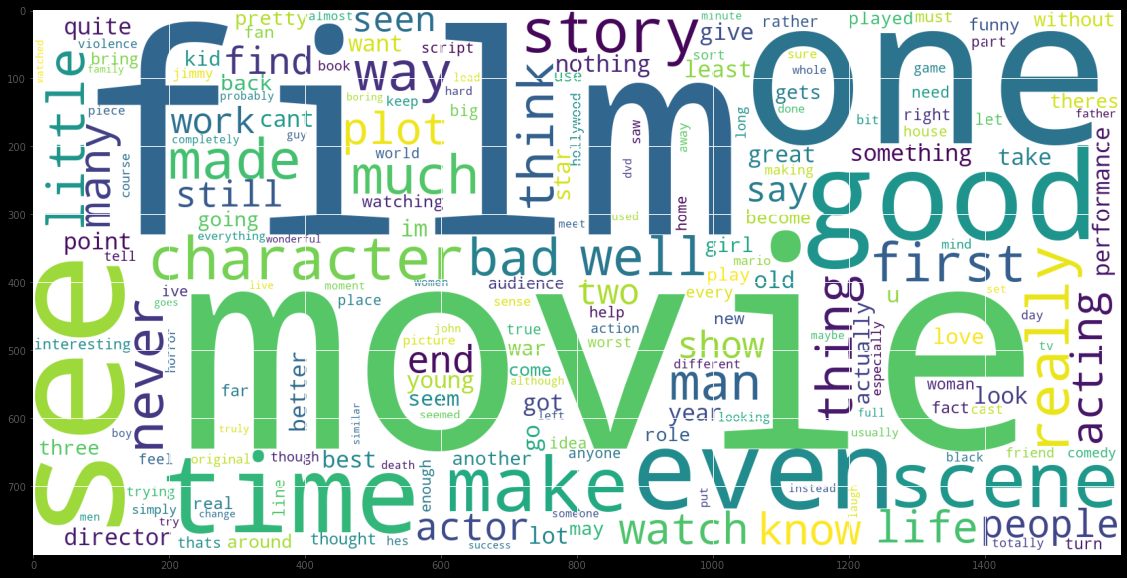

In [38]:
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(text[:150000])
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [39]:
#wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(positiveText[:100000])
#plt.figure( figsize=(20,10), facecolor='k')
#plt.imshow(wordcloud)

In [40]:
#wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(negativeText[:100000])
#plt.figure( figsize=(20,10), facecolor='k')
#plt.imshow(wordcloud)


In [41]:
counter = Counter(positiveText.split())
mostFrequentedWords = counter.most_common(10)

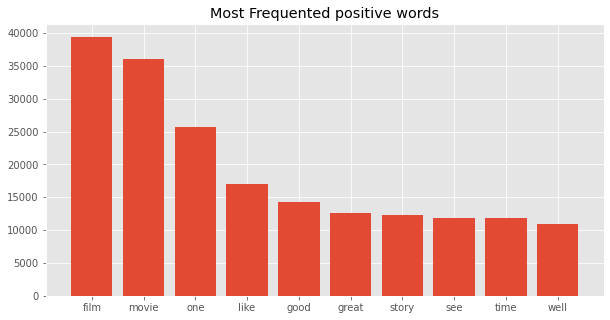

In [42]:
plt.figure(figsize=(10,5))
x,y= zip(*mostFrequentedWords)
plt.title("Most Frequented positive words")
plt.bar(x,y)
plt.show()

In [43]:
counter = Counter(negativeText.split())
mostFrequentedWords = counter.most_common(10)

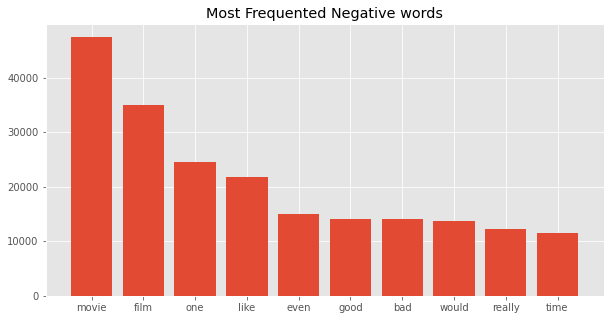

In [44]:
plt.figure(figsize=(10,5))
x,y= zip(*mostFrequentedWords)
plt.title("Most Frequented Negative words")
plt.bar(x,y)
plt.show()

### BiGram

In [45]:
def plotBigrams(text,title):
    bigrams = zip(text.split(), text.split()[1:])
    counts = Counter(bigrams)
    MostFrequentBiGrams = counts.most_common(15)
    plt.figure(figsize=(15,5))
    x,y = zip(*MostFrequentBiGrams)
    x = [f"{pair[0]} {pair[1]}" for pair in x]
    plt.title(title)
    plt.xticks(rotation = 25) # Rotates X-Axis Ticks by 45-degrees
    plt.bar(x,y)

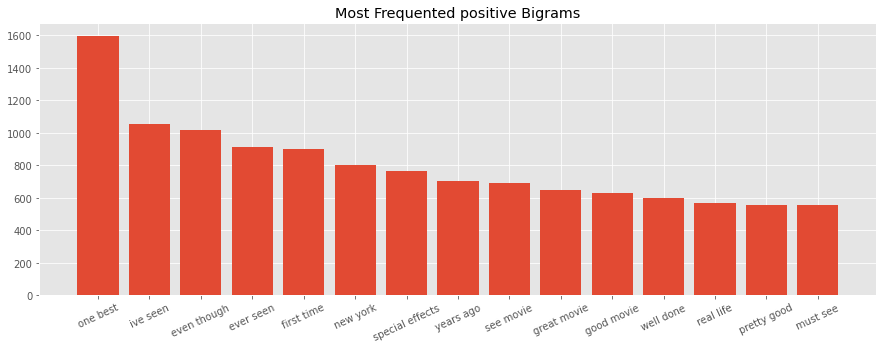

In [46]:
plotBigrams(positiveText,"Most Frequented positive Bigrams")

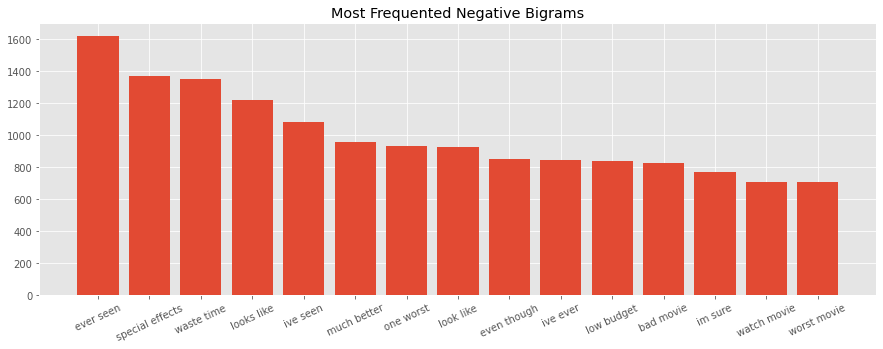

In [47]:
plotBigrams(negativeText,"Most Frequented Negative Bigrams")

### TriGrams

In [48]:
def plotTrigrams(text,title):
    bigrams = zip(text.split(),text.split()[1:],text.split()[2:])
    counts = Counter(bigrams)
    MostFrequentBiGrams = counts.most_common(15)
    plt.figure(figsize=(15,5))
    x,y = zip(*MostFrequentBiGrams)
    x = [f"{pair[0]} {pair[1]} {pair[2]}" for pair in x]
    plt.title(title)
    plt.xticks(rotation = 25) # Rotates X-Axis Ticks by 45-degrees
    plt.bar(x,y)

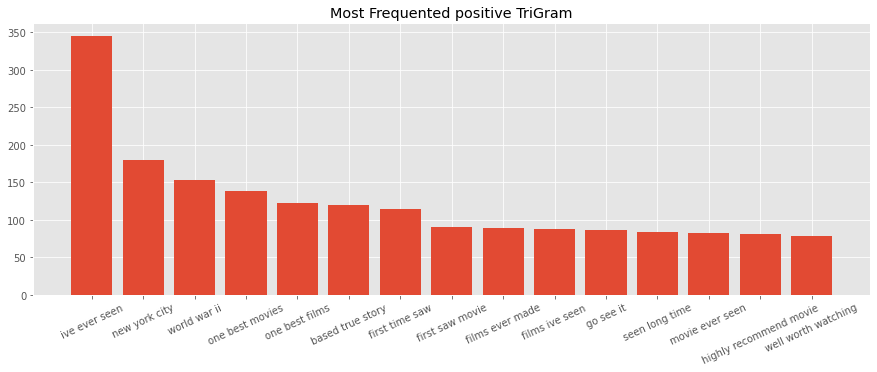

In [49]:
plotTrigrams(positiveText,"Most Frequented positive TriGram")

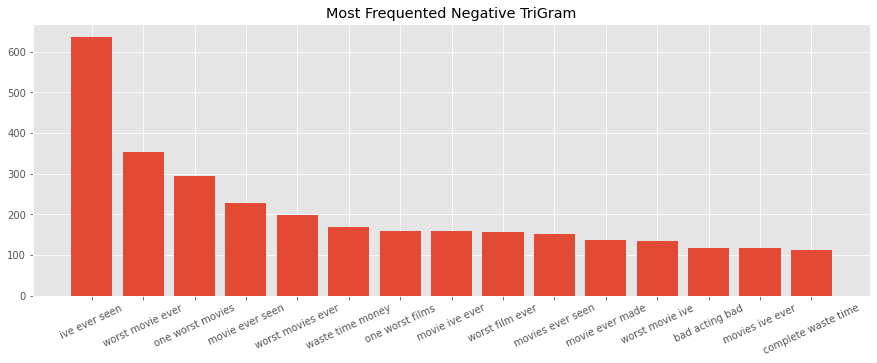

In [50]:
plotTrigrams(negativeText,"Most Frequented Negative TriGram")

In [51]:
data.dtypes

review         object
sentiment      object
target          int64
lenAlphabet     int64
lenWords        int64
dtype: object

In [52]:
x = list(data["review"])

In [53]:
y = np.array(data["target"])

In [54]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=.2)

In [55]:
print("Len of reviews in train =" , len(x_train))
print("Len of reviews in test  =" , len(x_test))

Len of reviews in train = 40000
Len of reviews in test  = 10000


In [56]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
wordIndex = tokenizer.word_index
len(wordIndex)

193811

In [57]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [58]:
#def getGloveVector(glovefile):
 #   with open(glovefile , mode='r',encoding='utf-8') as f:
  #      wordtoVector ={}
   #     
    #    for line in f :
     #       lineSplited = line.split()
      #      word = lineSplited[0]
       #     wordtoVector[word] = np.array(lineSplited[1:],dtype=np.float64)
    #return wordtoVector

In [59]:
word , *wordsl = "worda ahmed asd asdasd asdasd ".split()
word , wordsl

('worda', ['ahmed', 'asd', 'asdasd', 'asdasd'])

In [64]:
def embeddingForVoc(filePath,word_index,embedding_dim=50):
    vocab_size = len(word_index) + 1
    embeddingMatrix = np.zeros((vocab_size,embedding_dim))
    
    with open(filePath ,encoding='utf-8') as f:
        for line in f:
            word , *vector = line.split()
            if word in word_index:
                idx = wordIndex[word]
                embeddingMatrix[idx] = np.array(vector,dtype=np.float32)[:embedding_dim]
    return embeddingMatrix

In [77]:
embeddingMatrix = embeddingForVoc('/content/glove.6B.100d.txt',wordIndex,100)

In [78]:
embeddingMatrix.shape

(193812, 100)

In [79]:
maxLen = 200
vocabLen = len(wordIndex) + 1
embeddingLen = embeddingMatrix.shape[1]
print(f'Max length of words in review {maxLen}')
print(f'Number of Words {vocabLen}')
print(f'Embedding Dimention of each word {embeddingLen}')

Max length of words in review 200
Number of Words 193812
Embedding Dimention of each word 100


In [80]:
x_train_indices = tokenizer.texts_to_sequences(x_train)
x_train_indices = pad_sequences(x_train_indices,maxlen=maxLen , padding='post')

In [81]:
x_test_indices = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(x_test_indices,maxlen=maxLen , padding='post')

### Model Building

In [82]:
model = Sequential([
    # Embedding Layer
    Embedding(vocabLen , output_dim = embeddingLen , input_length = maxLen ,
             weights = [embeddingMatrix], trainable=False),
    # Conv 1D to reduce input dimen
    Conv1D(embeddingLen,10,activation='relu'),
    #
    Bidirectional(LSTM(128,return_sequences=True)),
    LSTM(64),
    Dropout(.4),
    Dense(1,activation='sigmoid')
])

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          19381200  
                                                                 
 conv1d_2 (Conv1D)           (None, 191, 100)          100100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 191, 256)         234496    
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [84]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [85]:
es = EarlyStopping(monitor='val_accuracy',
                patience=2)

In [ ]:
history = model.fit(x_train_indices,y_train,validation_data=(x_test_indices,y_test) , epochs= 5,callbacks=es)

Epoch 1/5
1250/1250 [==============================] - 805s 640ms/step - loss: 0.6902 - accuracy: 0.5235 - val_loss: 0.6891 - val_accuracy: 0.5155
Epoch 2/5
1250/1250 [==============================] - 803s 643ms/step - loss: 0.5292 - accuracy: 0.7253 - val_loss: 0.4338 - val_accuracy: 0.7975
Epoch 3/5
 574/1250 [============>.................] - ETA: 6:51 - loss: 0.3848 - accuracy: 0.8310